Homework-4,
CS 522, Fall-2022,
Chandrashekar Panjhazari

Dataset for zipcoded was downloaded from: https://www.cs.utexas.edu/~scottm/cs312/handouts/SectionHandouts/ZipCode.html

References:

1) https://jcutrer.com/python/learn-geopandas-plotting-usmaps

2) https://geopandas.org/en/stable/#

3) https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html

4) https://stackoverflow.com/questions/62265007/can-i-get-cluster-centroids-after-clustering-the-spatial-latitude-longitude-d

In [98]:
!pip install geopandas # Helps working with geospatial data


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [99]:
# Importing libraries 

import numpy as np                         
import pandas as pd                   
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from shapely.geometry import Point
import geopandas as gpd

In [100]:
# Importing a datafile (i.e .csv file)

df = pd.read_csv('USA_zipcodes.csv')

In [101]:
# Looking at the length of the dataset

len(df) 

40709

In [102]:
# Looking at the first rows of the dataframe

df.head()

,Zipcode,ZipCodeType,City,State,LocationType,Lat,Long,Location,Decommisioned,TaxReturnsFiled,EstimatedPopulation,TotalWages
0,98357,PO BOX,NEAH BAY,WA,PRIMARY,48.33,-124.63,NA-US-WA-NEAH BAY,False,473.0,877.0,12642512.0
1,98350,PO BOX,LA PUSH,WA,PRIMARY,47.90,-124.61,NA-US-WA-LA PUSH,False,NaN,NaN,NaN
2,98326,STANDARD,CLALLAM BAY,WA,PRIMARY,48.17,-124.53,NA-US-WA-CLALLAM BAY,False,NaN,NaN,NaN
3,97464,PO BOX,OPHIR,OR,PRIMARY,42.50,-124.41,NA-US-OR-OPHIR,False,NaN,NaN,NaN
4,97491,PO BOX,WEDDERBURN,OR,PRIMARY,42.45,-124.40,NA-US-OR-WEDDERBURN,False,NaN,NaN,NaN


In [103]:
# Dropping unwanted columns from the dataframe

df = df.drop(df.columns[[1, 2, 3, 4, 7, 8, 9, 10, 11 ]], axis=1)

In [104]:
# Looking at the first rows of the dataframe
df.head()

,Zipcode,Lat,Long
0,98357,48.33,-124.63
1,98350,47.90,-124.61
2,98326,48.17,-124.53
3,97464,42.50,-124.41
4,97491,42.45,-124.40


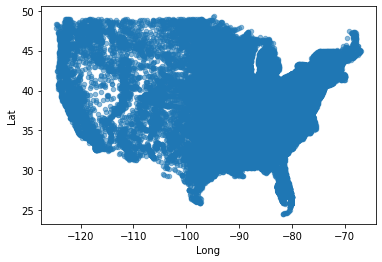

In [105]:
# Plotting the US Zip Codes
df.plot(kind="scatter", x="Long", y="Lat", alpha=0.5)
plt.show()

In [106]:
# Reading the Dataset
states = gpd.read_file('usa-states-census-2014.shx')
type(states)

geopandas.geodataframe.GeoDataFrame

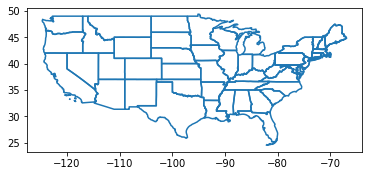

In [107]:
# Plotting the US Boundaries
states.boundary.plot()

In [108]:
# Converting the Latitudes and Longitutdes to Geopandas
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Long, df.Lat))

In [109]:
# looking at the first rows of the dataframe
gdf.head()

,Zipcode,Lat,Long,geometry
0,98357,48.33,-124.63,POINT (-124.63000 48.33000)
1,98350,47.90,-124.61,POINT (-124.61000 47.90000)
2,98326,48.17,-124.53,POINT (-124.53000 48.17000)
3,97464,42.50,-124.41,POINT (-124.41000 42.50000)
4,97491,42.45,-124.40,POINT (-124.40000 42.45000)


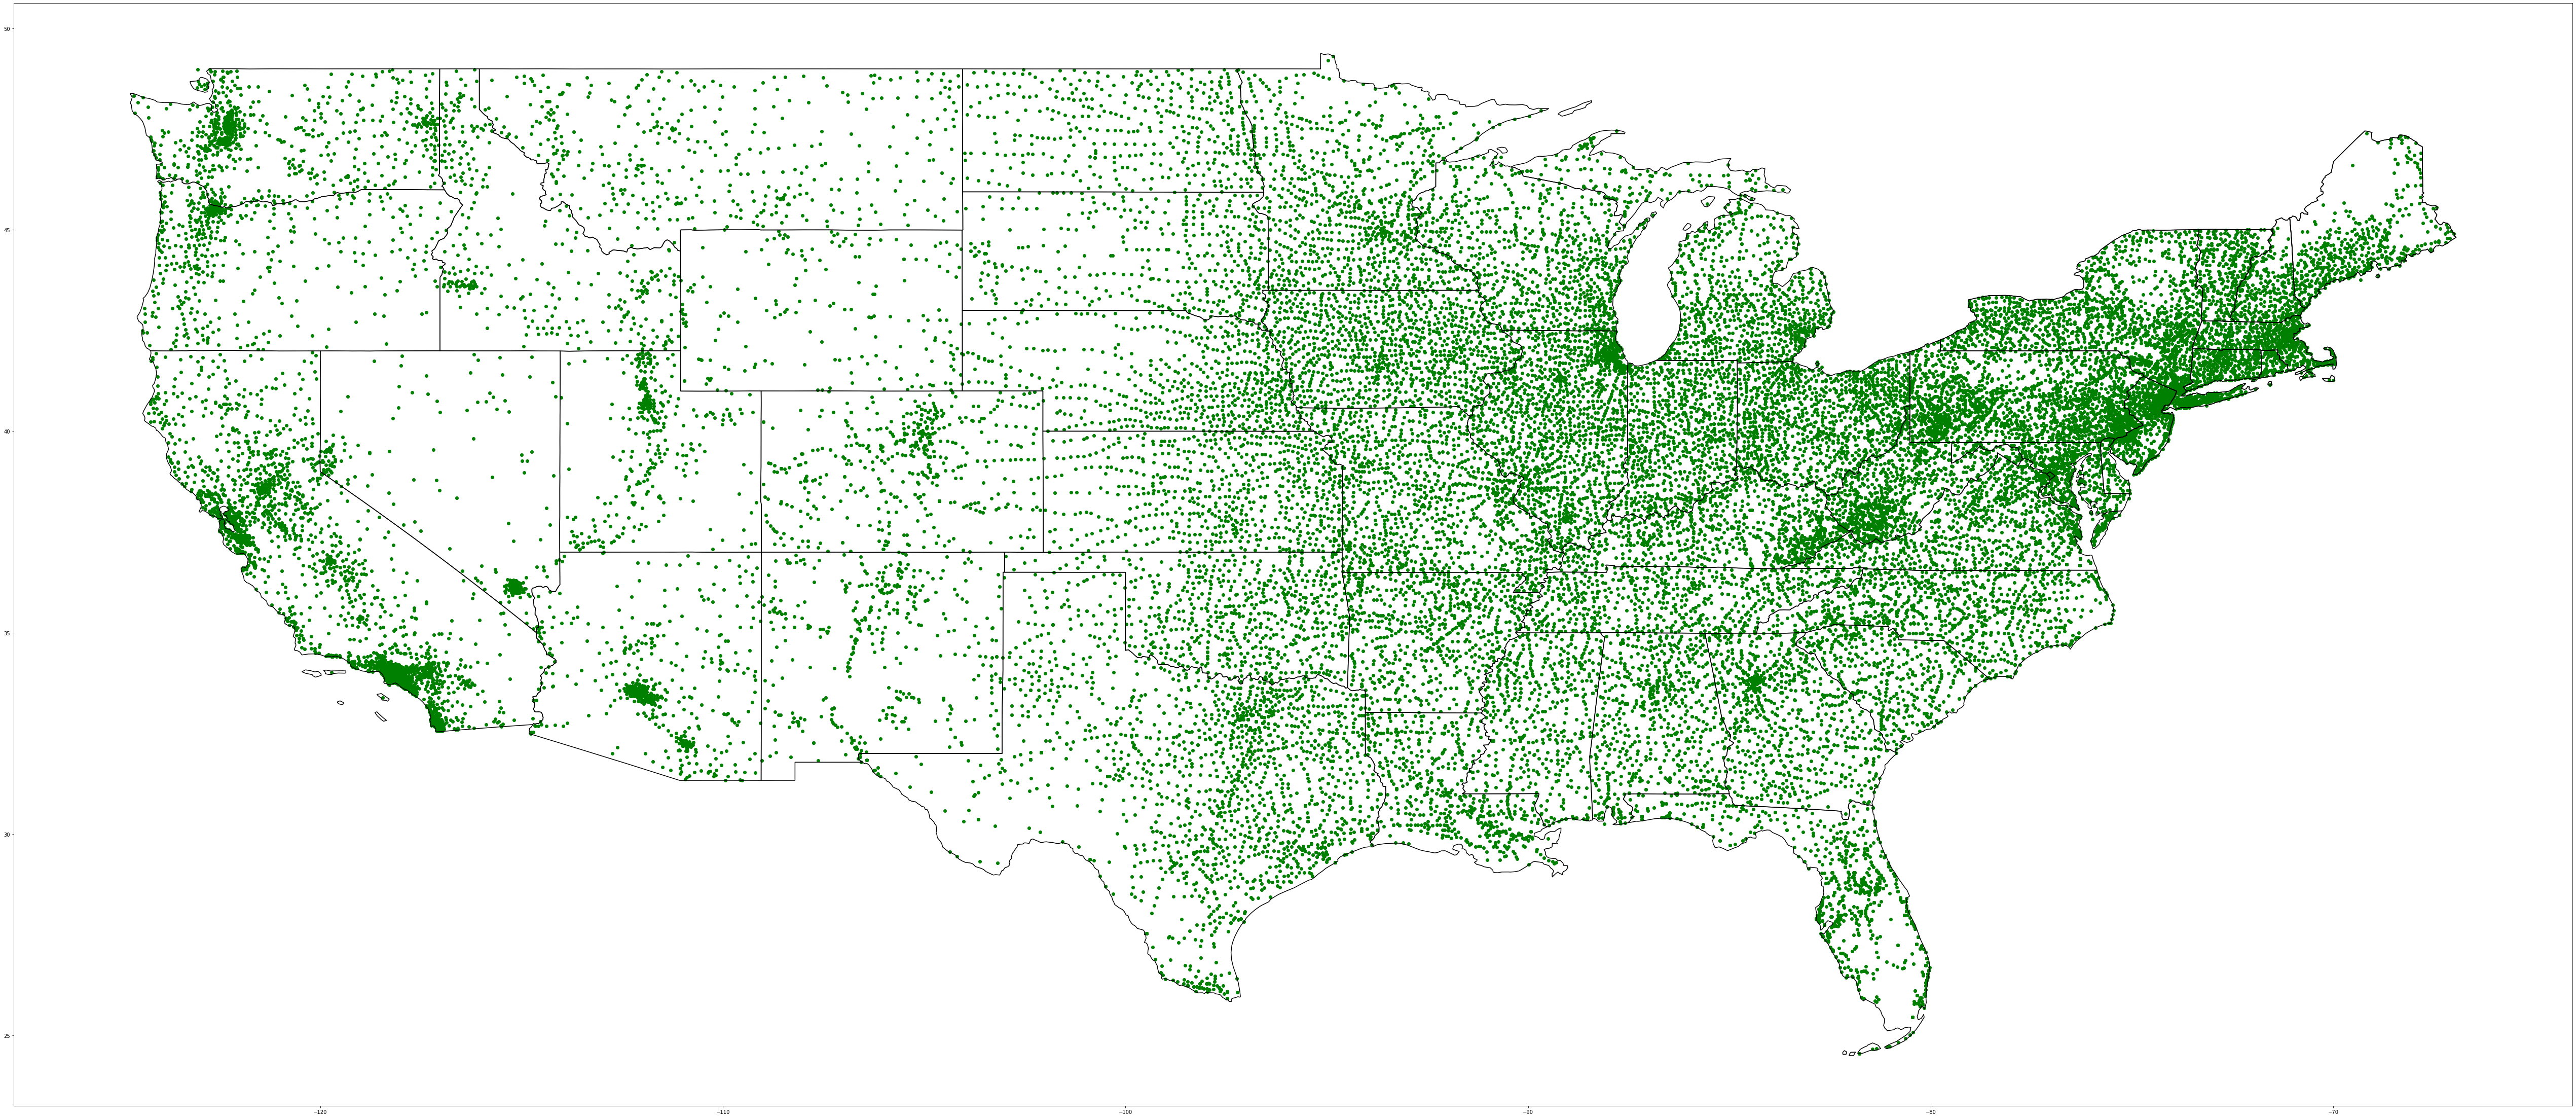

In [110]:
# Plotting the US map with Zip Codes
fig = plt.figure(1, figsize=(100,40)) 
ax = fig.add_subplot()
states.boundary.plot(ax=ax, color='black')
gdf.plot(ax=ax, color='green')
plt.show()



**Applying DBSCAN Algorithm to US Zipcodes Dataset**

In [111]:
# Importing the Libraries
import pandas as pd, numpy as np, matplotlib.pyplot as plt, time
from sklearn.cluster import DBSCAN
from sklearn import metrics
from geopy.distance import great_circle
from shapely.geometry import MultiPoint



In [112]:
X = gdf[['Lat', 'Long']].to_numpy()
# define the number of kilometers in one radian
kms_per_radian = 6371.0088
#  define epsilon as 0.5 kilometers, converted to radians for use by haversine
epsilon = 0.5/kms_per_radian  
db = DBSCAN(eps = epsilon, min_samples = 5, algorithm ='ball_tree', metric ='haversine').fit(np.radians(X))
cluster_labels=db.labels_
num_clusters = len(set(cluster_labels))
clusters = pd.Series([X[cluster_labels==n] for n in range(num_clusters-1)])
print('Number of clusters: {}'.format(num_clusters))


Number of clusters: 448


In [113]:
# It determines the center point of the cluster and which point is closer to the center
def get_centermost_point(cluster):
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
    centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
    return tuple(centermost_point)
centermost_points = clusters.map(get_centermost_point)

In [114]:

Latitudes, Longtitudes = zip(*centermost_points)
representative_points = pd.DataFrame({'Lat':Latitudes,'Long':Longtitudes})
rs = representative_points.apply(lambda row: gdf[(gdf['Lat']==row['Lat']) & (gdf['Long']==row['Long'])].iloc[0], axis =1)

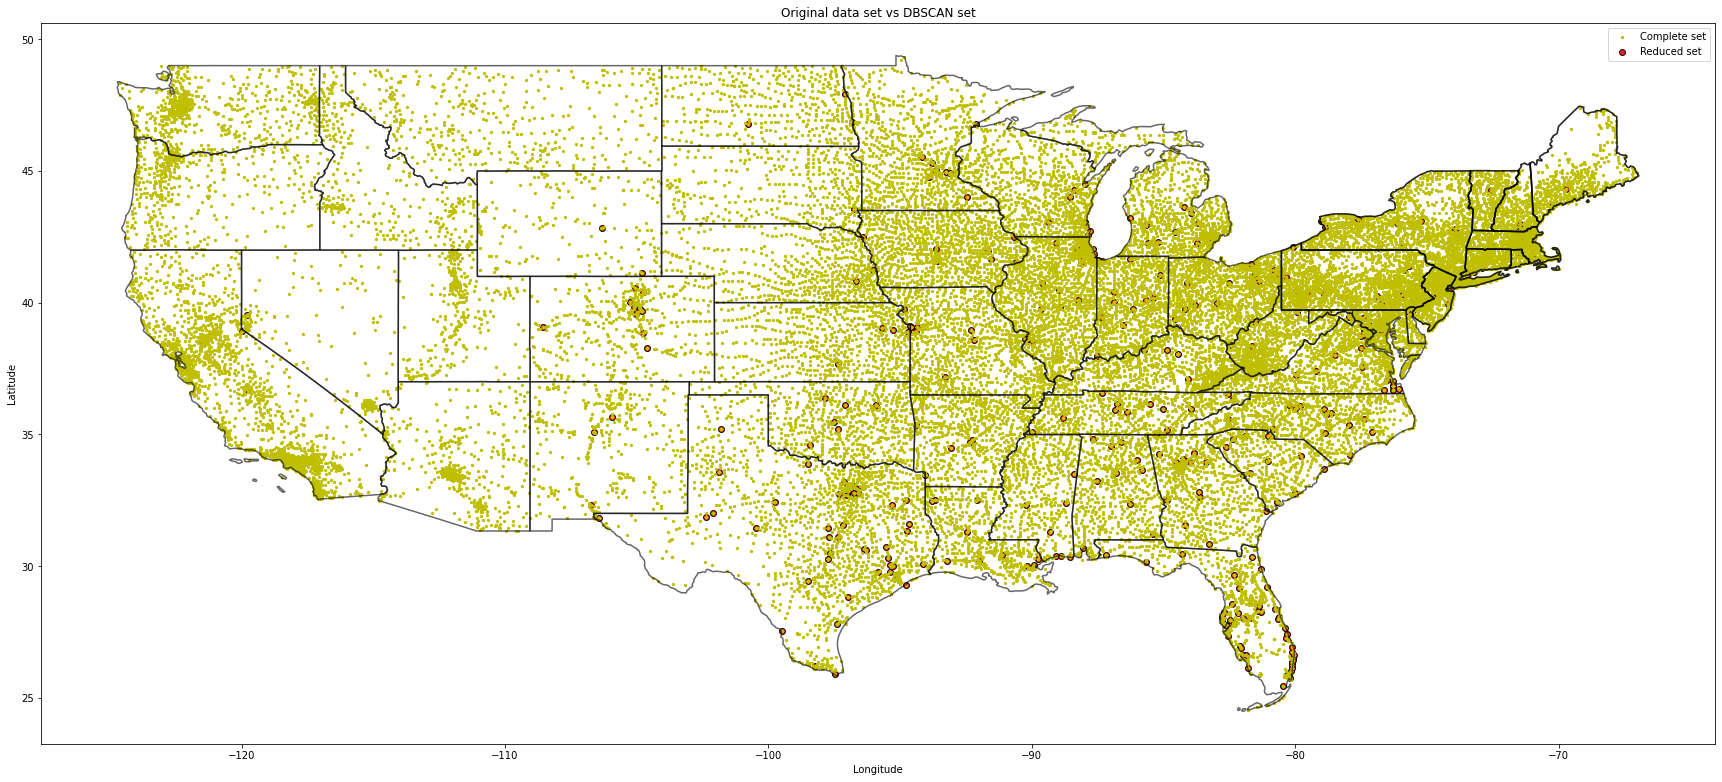

In [115]:
# Plotting the Original Data Set vs Reduced DBSCAN Set
fig,ax = plt.subplots(figsize=[30, 15])
states.boundary.plot(ax=ax, color='black',alpha=0.6)
rs_scatter = ax.scatter(rs['Long'], rs['Lat'], c='r', edgecolor='black', alpha=0.9) 
gdf_scatter = ax.scatter(gdf['Long'], gdf['Lat'], c='y', s=5)
ax.set_title('Original data set vs DBSCAN set')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend([gdf_scatter, rs_scatter], ['Complete set', 'Reduced set'], loc='upper right')
plt.show()